<a href="https://colab.research.google.com/github/Wwymouu/Background-removal-using-deep-learning/blob/master/ebay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf 
print(tf.__version__)

1.15.2


In [4]:
import os
import sys
import random
import math
import numpy as np
import json
import datetime
import skimage.draw
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/uzh/RL 4 marketing/Mask_RCNN-master/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

%matplotlib inline 

# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)

# # Directory of images to run detection on
# IMAGE_DIR = os.path.join("/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset/train/", "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class ObjectConfig(Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # Background + object

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = ObjectConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

##Dataset

In [0]:
class ObjectDataset(utils.Dataset):

    def load_object(self, dataset_dir, subset, class_ids=None,):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # # Add classes. We have 7 classes to add.
        # self.add_class("object", 1, "backpack")
        # self.add_class("object", 2, "bottle")
        # self.add_class("object", 3, "cup")
        # self.add_class("object", 4, "laptop")
        # self.add_class("object", 5, "mouse")
        # self.add_class("object", 6, "cell phone")
        # self.add_class("object", 7, "book")


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # IMAGE_DIR = os.path.join(dataset_dir, "images")
        # image_ids = next(os.walk(IMAGE_DIR))[2]
        # print(image_ids)

        # # Add images
        # for image_id in image_ids:
        #     self.add_image(
        #         "object",
        #         image_id=image_id,
        #         path=os.path.join(dataset_dir, "images/{}".format(image_id)))


        annFile = os.path.join(dataset_dir, "coco_instances.json")
        # print(f'Annotation file: {annFile}')
        coco = COCO(annFile)

        image_dir = os.path.join(dataset_dir, "images")
        # print("image_dir:", image_dir)  
        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("object", i, coco.loadCats(i)[0]["name"])
        print("class_ids", class_ids)
        # Add images
        for i in image_ids:
            self.add_image(
                "object", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
               
    def load_mask(self, image_id):

        """Load instance masks for the given image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        # print('image_info',image_info)
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # print('annotations', annotations)
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id']
            # print("class_id", class_id)
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(self.__class__, self, self).load_mask(image_id)
                       

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [7]:
dataset_dir = os.path.abspath("/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset_1/")

dataset_train = ObjectDataset()
dataset_train.load_object(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ObjectDataset()
dataset_val.load_object(dataset_dir, "val")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
class_ids [1, 2, 3, 4, 5, 6, 7]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
class_ids [1, 2, 3, 4, 5, 6, 7]


In [0]:
class_names = ['backpacks', 'mouse', 'phone', 'laptop', 'books', 'bottles', 'cups']

image_ids:  [55 76 91 52]
/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset_1/train/images/00000055.jpg


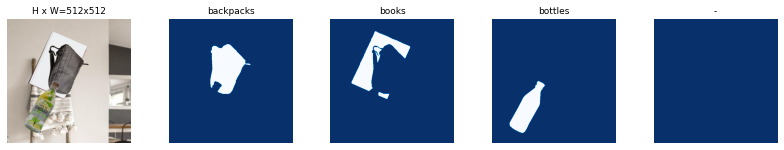

/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset_1/train/images/00000076.jpg


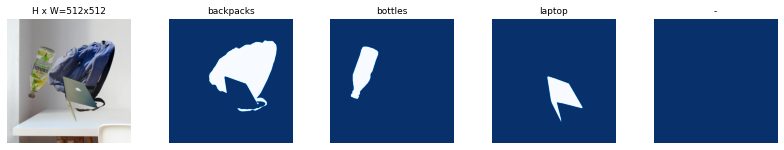

/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset_1/train/images/00000091.jpg


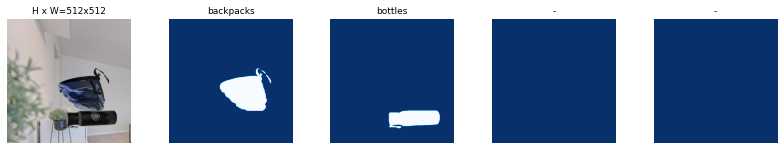

/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset_1/train/images/00000052.jpg


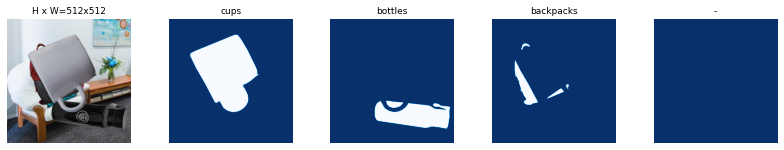

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
print("image_ids: ", image_ids)
for image_id in image_ids:
    if image_id >= 100:
        image_path = os.path.join(dataset_dir, "train/images/00000{}.jpg".format(image_id))
    elif image_id < 10:
        image_path = os.path.join(dataset_dir, "train/images/0000000{}.jpg".format(image_id))
    else:
        image_path = os.path.join(dataset_dir, "train/images/000000{}.jpg".format(image_id))
    print(image_path)
    image = skimage.io.imread(image_path)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids-1, class_names)

##Create Model

In [10]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

##Training

In [12]:
# Train the head branches
# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')


Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/uzh/RL 4 marketing/Mask_RCNN-master/logs/object20200424T0815/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDis

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
100/100 [==============================] - 189s 2s/step - loss: 1.5907 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.6817 - mrcnn_mask_loss: 0.3698 - val_loss: 1.0548 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 0.3202 - val_mrcnn_class_loss: 0.1753 - val_mrcnn_bbox_loss: 0.4844 - val_mrcnn_mask_loss: 0.2597

Epoch 2/10
100/100 [==============================] - 154s 2s/step - loss: 1.1380 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.2733 - val_loss: 0.9708 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.4236 - val_mrcnn_class_loss: 0.1883 - val_mrcnn_bbox_loss: 0.3781 - val_mrcnn_mask_loss: 0.2635
Epoch 3/10
100/100 [==============================] - 156s 2s/step - loss: 0.9659 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2653 - mrcnn_class_loss: 0.1565 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.2349 - val_loss: 0.6886 - val_rpn_class_

## Create Model and Load Trained Weights

In [14]:
class InferenceConfig(ObjectConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  /content/drive/My Drive/uzh/RL 4 marketing/Mask_RCNN-master/logs/object20200424T0815/mask_rcnn_object_0010.h5
Re-starting from epoch 10


## Run Object Detection

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[1]


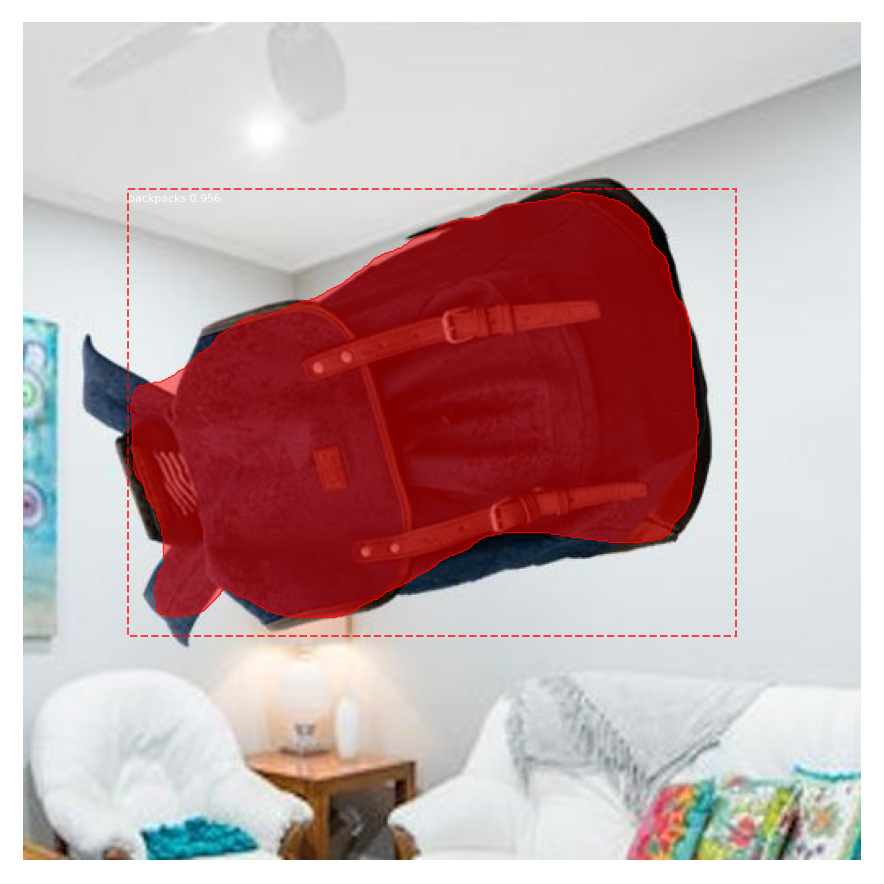

In [49]:
# Directory of images to run detection on
IMAGE_DIR = os.path.abspath("/content/drive/My Drive/uzh/RL 4 marketing/ebay_dataset_1/val/images")

# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread(os.path.join(IMAGE_DIR, "00000142.jpg"))
# image = skimage.io.imread("/content/drive/My Drive/uzh/RL 4 marketing/download.jpg")
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
print(r['class_ids'])

# print(r['class_ids']-1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids']-1, 
                            class_names, r['scores'])

In [0]:
def apply_mask(image, mask):
    image[:, :, 0] = np.where(
        mask == 0,
        125,
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        12,
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        15,
        image[:, :, 2]
    )
    return image

In [0]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        print(label)
        if label in class_names:
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

        # apply mask for the image
        image = apply_mask(image, mask)
        
    return image

Test on a random image


In [0]:
from google.colab.patches import cv2_imshow

backpacks


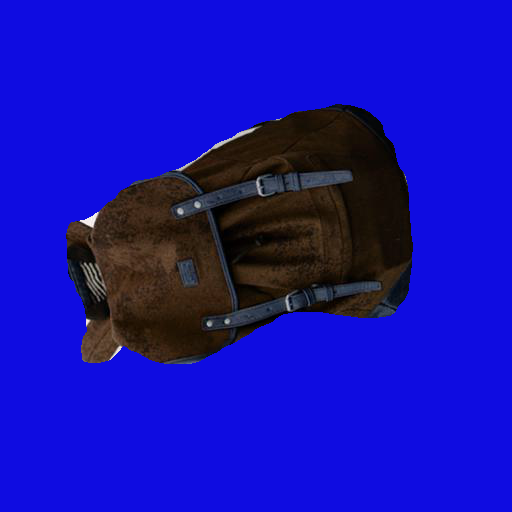

In [56]:
frame = display_instances(
      image, r['rois'], r['masks'], r['class_ids']-1, class_names, r['scores'])

cv2_imshow(frame)